# 2 layer synthetic inversion

Here we try to recover the true Layer 2 topography with a gravity inversion. The gravity data is the forward gravity of Layer 1 and 2, representing a perfect gravity survey with no error. The inputs into the inversion are a full resolution Layer 1, representing the `ice surface`, and a low resolution Layer 2, representing the `bed topography`, which has been created through the random sampling and grid of 30 contraint points. In an Antarctic setting, these points represent single seismic survey locations which image the elevation of Layer 2. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth 

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go

import os

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /home/matt/mambaforge/envs/RIS_gravity_inversion/share/proj failed


# Set region and parameters

Use the same regions and parameters as `synthetic_model_simple_2layer.ipynb`

In [2]:
# set grid parameters
spacing = 1e3
registration = "g"
inversion_region = [0, 80e3, 0, 60e3]

# set gravity observation parameters
grav_observation_height = 1000
grav_spacing = 1e3  # true spacing was 2km for sampled, 1km for full res

buffer_region = utils.alter_region(
    inversion_region,
    buffer=12e3,
)[1]


print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [0, 80000.0, 0, 60000.0]
buffer region =  [-12000, 92000, -12000, 72000]


# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [3]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

true_layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

starting_layer2 = xr.open_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr"
)["z"]

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
true_layer2 = true_layer2.astype(np.float64)
starting_layer2 = starting_layer2.astype(np.float64)

# resample all layer to same spacing / extent
layer1 = fetch.resample_grid(
    layer1,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
true_layer2 = fetch.resample_grid(
    true_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)
starting_layer2 = fetch.resample_grid(
    starting_layer2,
    region=buffer_region,
    spacing=spacing,
    registration=registration,
)

print(utils.get_grid_info(starting_layer2))
starting_layer2

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


returning original grid
returning original grid
returning original grid
(1000.0, [-12000.0, 92000.0, -12000.0, 72000.0], -932.234313965, -540.887084961, 'g')


<xarray.DataArray 'z' (y: 85, x: 105)>
dask.array<astype, shape=(85, 105), dtype=float64, chunksize=(85, 105), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -1.2e+04 -1.1e+04 -1e+04 ... 9e+04 9.1e+04 9.2e+04
  * y        (y) float64 -1.2e+04 -1.1e+04 -1e+04 ... 7e+04 7.1e+04 7.2e+04
Attributes:
    actual_range:  [-932.2343139648438, -540.8870849609375]
    long_name:     z

## gravity data
* full resolution gravity grid
* gravity observations

In [5]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple_2layer.zarr")

# use full grid
grav = vd.grid_to_table(synthetic_gravity.astype(np.float64))

# set standard column names
grav = grav.rename(columns={'forward_total':'Gobs'})

# remove other columns
grav = grav[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav.Gobs -= grav.Gobs.mean()

print(f"gravity: {len(grav)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav.z))}")

# grid the observed gravity
Gobs = grav.set_index(["y", "x"]).to_xarray().Gobs

grav

gravity: 4941 points
gravity avg. elevation: 1000


,x,y,Gobs,z
0,0.0,0.0,14.568305,1000.0
1,1000.0,0.0,14.080812,1000.0
2,2000.0,0.0,13.592559,1000.0
3,3000.0,0.0,13.105121,1000.0
4,4000.0,0.0,12.619702,1000.0
...,...,...,...,...
4936,76000.0,60000.0,0.762734,1000.0
4937,77000.0,60000.0,0.839472,1000.0
4938,78000.0,60000.0,0.924361,1000.0
4939,79000.0,60000.0,1.017314,1000.0


## constraint points

In [6]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all,
    inversion_region,
)

print(f"bathymetry control points:{len(constraint_points)}")

bathymetry control points:30


## plot inputs

returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


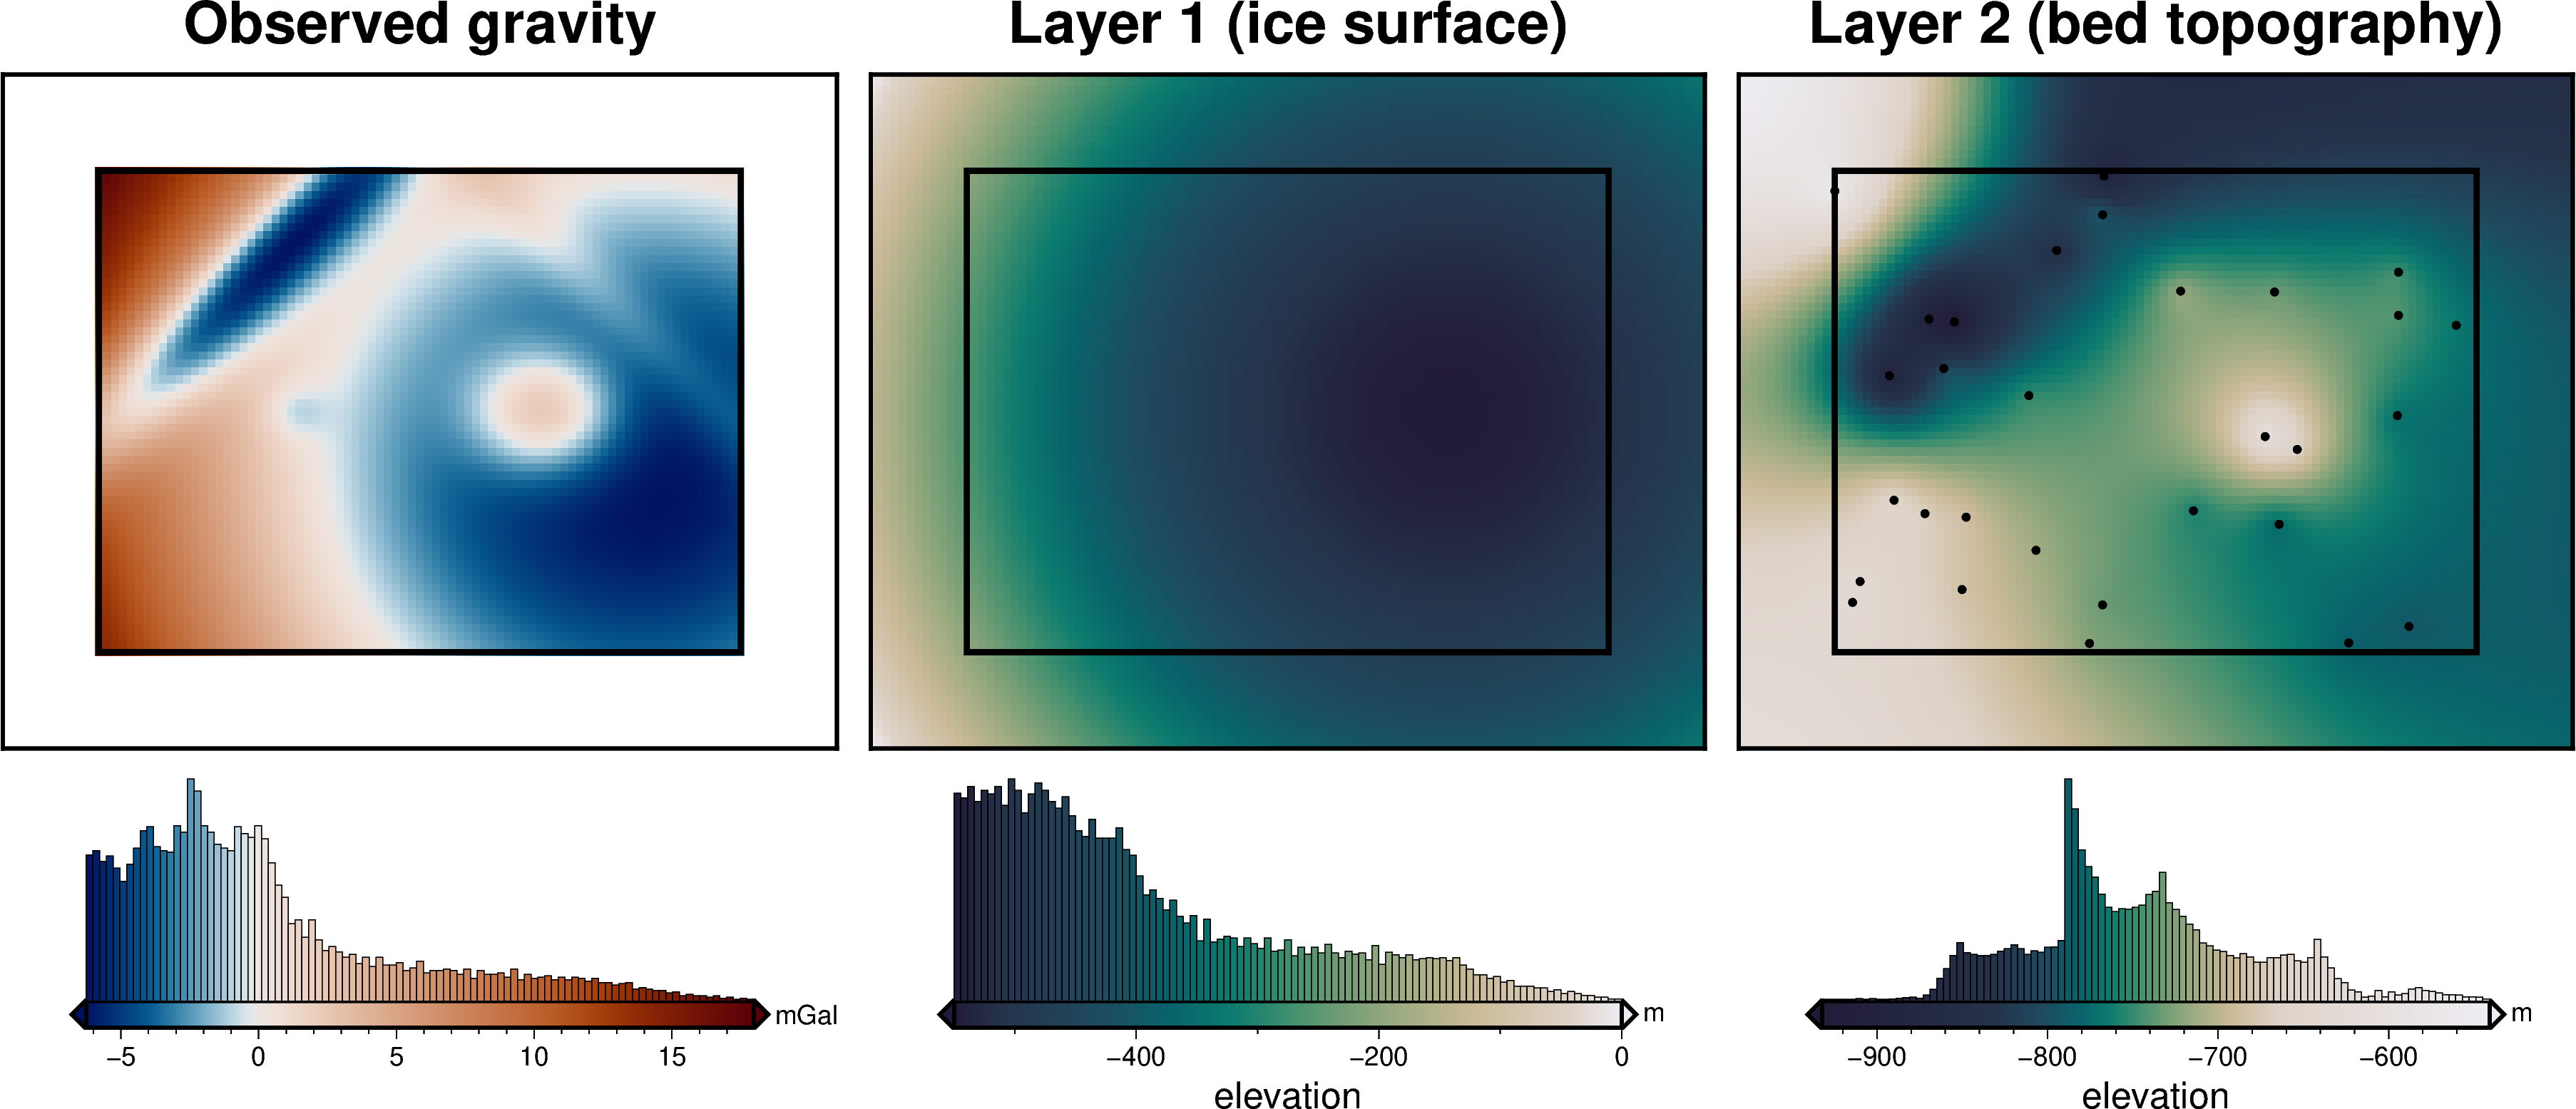

In [7]:
# plot observed gravity
fig = maps.plot_grd(
    grid=Gobs,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Observed gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)

# plot layer 1
fig = maps.plot_grd(
    grid=layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 1 (ice surface)",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 2 (bed topography)",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)

# plot constraint points
fig.plot(
    x=constraint_points.x,
    y=constraint_points.y,
    style="c.1c",
    color="black",
)

fig.show()

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast across Layer 1 (air-ice) and Layer 2 (ice-bed). Since we want to invert for Layer 2, we need to remove the component of this gravity from Layer 1. To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of Layer 1. The prisms extend above or below this reference, towards Layer 1. Prisms above the reference are assigned a positive density contrast ($\rho_{ice}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{ice}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bed elevation doesn't intersect Layer 1. This means the Layer 1 density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Ice prisms

In [8]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    top=layer1,
    bottom=layer1.values.mean(),
    density=xr.where(layer1>=layer1.values.mean(), 917, -917),
)

plots.show_prism_layers(
    [layer1_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    zscale=100,
    clip_box=False,
    log_scale=False,
)

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:41: PyVistaDeprecationWarning: `ipyvtklink` backend is deprecated and has been replaced by the `trame` backend.
  warnings.warn(


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## ice gravity

In [9]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav,
    names=['layer1_prisms'],
    remove_mean=True,
    progressbar=True,
    plot=False,
)

grav['layer1_forward'] = layer1_df.forward_total

# subtract from observed gravity
grav['Gobs_corr']=grav.Gobs - grav.layer1_forward

# center on 0
grav['Gobs_corr'] -= grav['Gobs_corr'].mean()

# grid the results
layer1_forward = grav.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= layer1_forward.values.mean()
Gobs_corr -= Gobs_corr.values.mean()
grav

  0%|          | 0/4941 [00:00<?, ?it/s]

,x,y,Gobs,z,layer1_forward,Gobs_corr
0,0.0,0.0,14.568305,1000.0,9.079567,5.488738
1,1000.0,0.0,14.080812,1000.0,8.764314,5.316498
2,2000.0,0.0,13.592559,1000.0,8.450560,5.141999
3,3000.0,0.0,13.105121,1000.0,8.139163,4.965958
4,4000.0,0.0,12.619702,1000.0,7.830770,4.788932
...,...,...,...,...,...,...
4936,76000.0,60000.0,0.762734,1000.0,-0.331436,1.094169
4937,77000.0,60000.0,0.839472,1000.0,-0.239442,1.078913
4938,78000.0,60000.0,0.924361,1000.0,-0.142035,1.066397
4939,79000.0,60000.0,1.017314,1000.0,-0.039275,1.056589


returning grid with new region and/or registration, same spacing
returning grid with new region and/or registration, same spacing


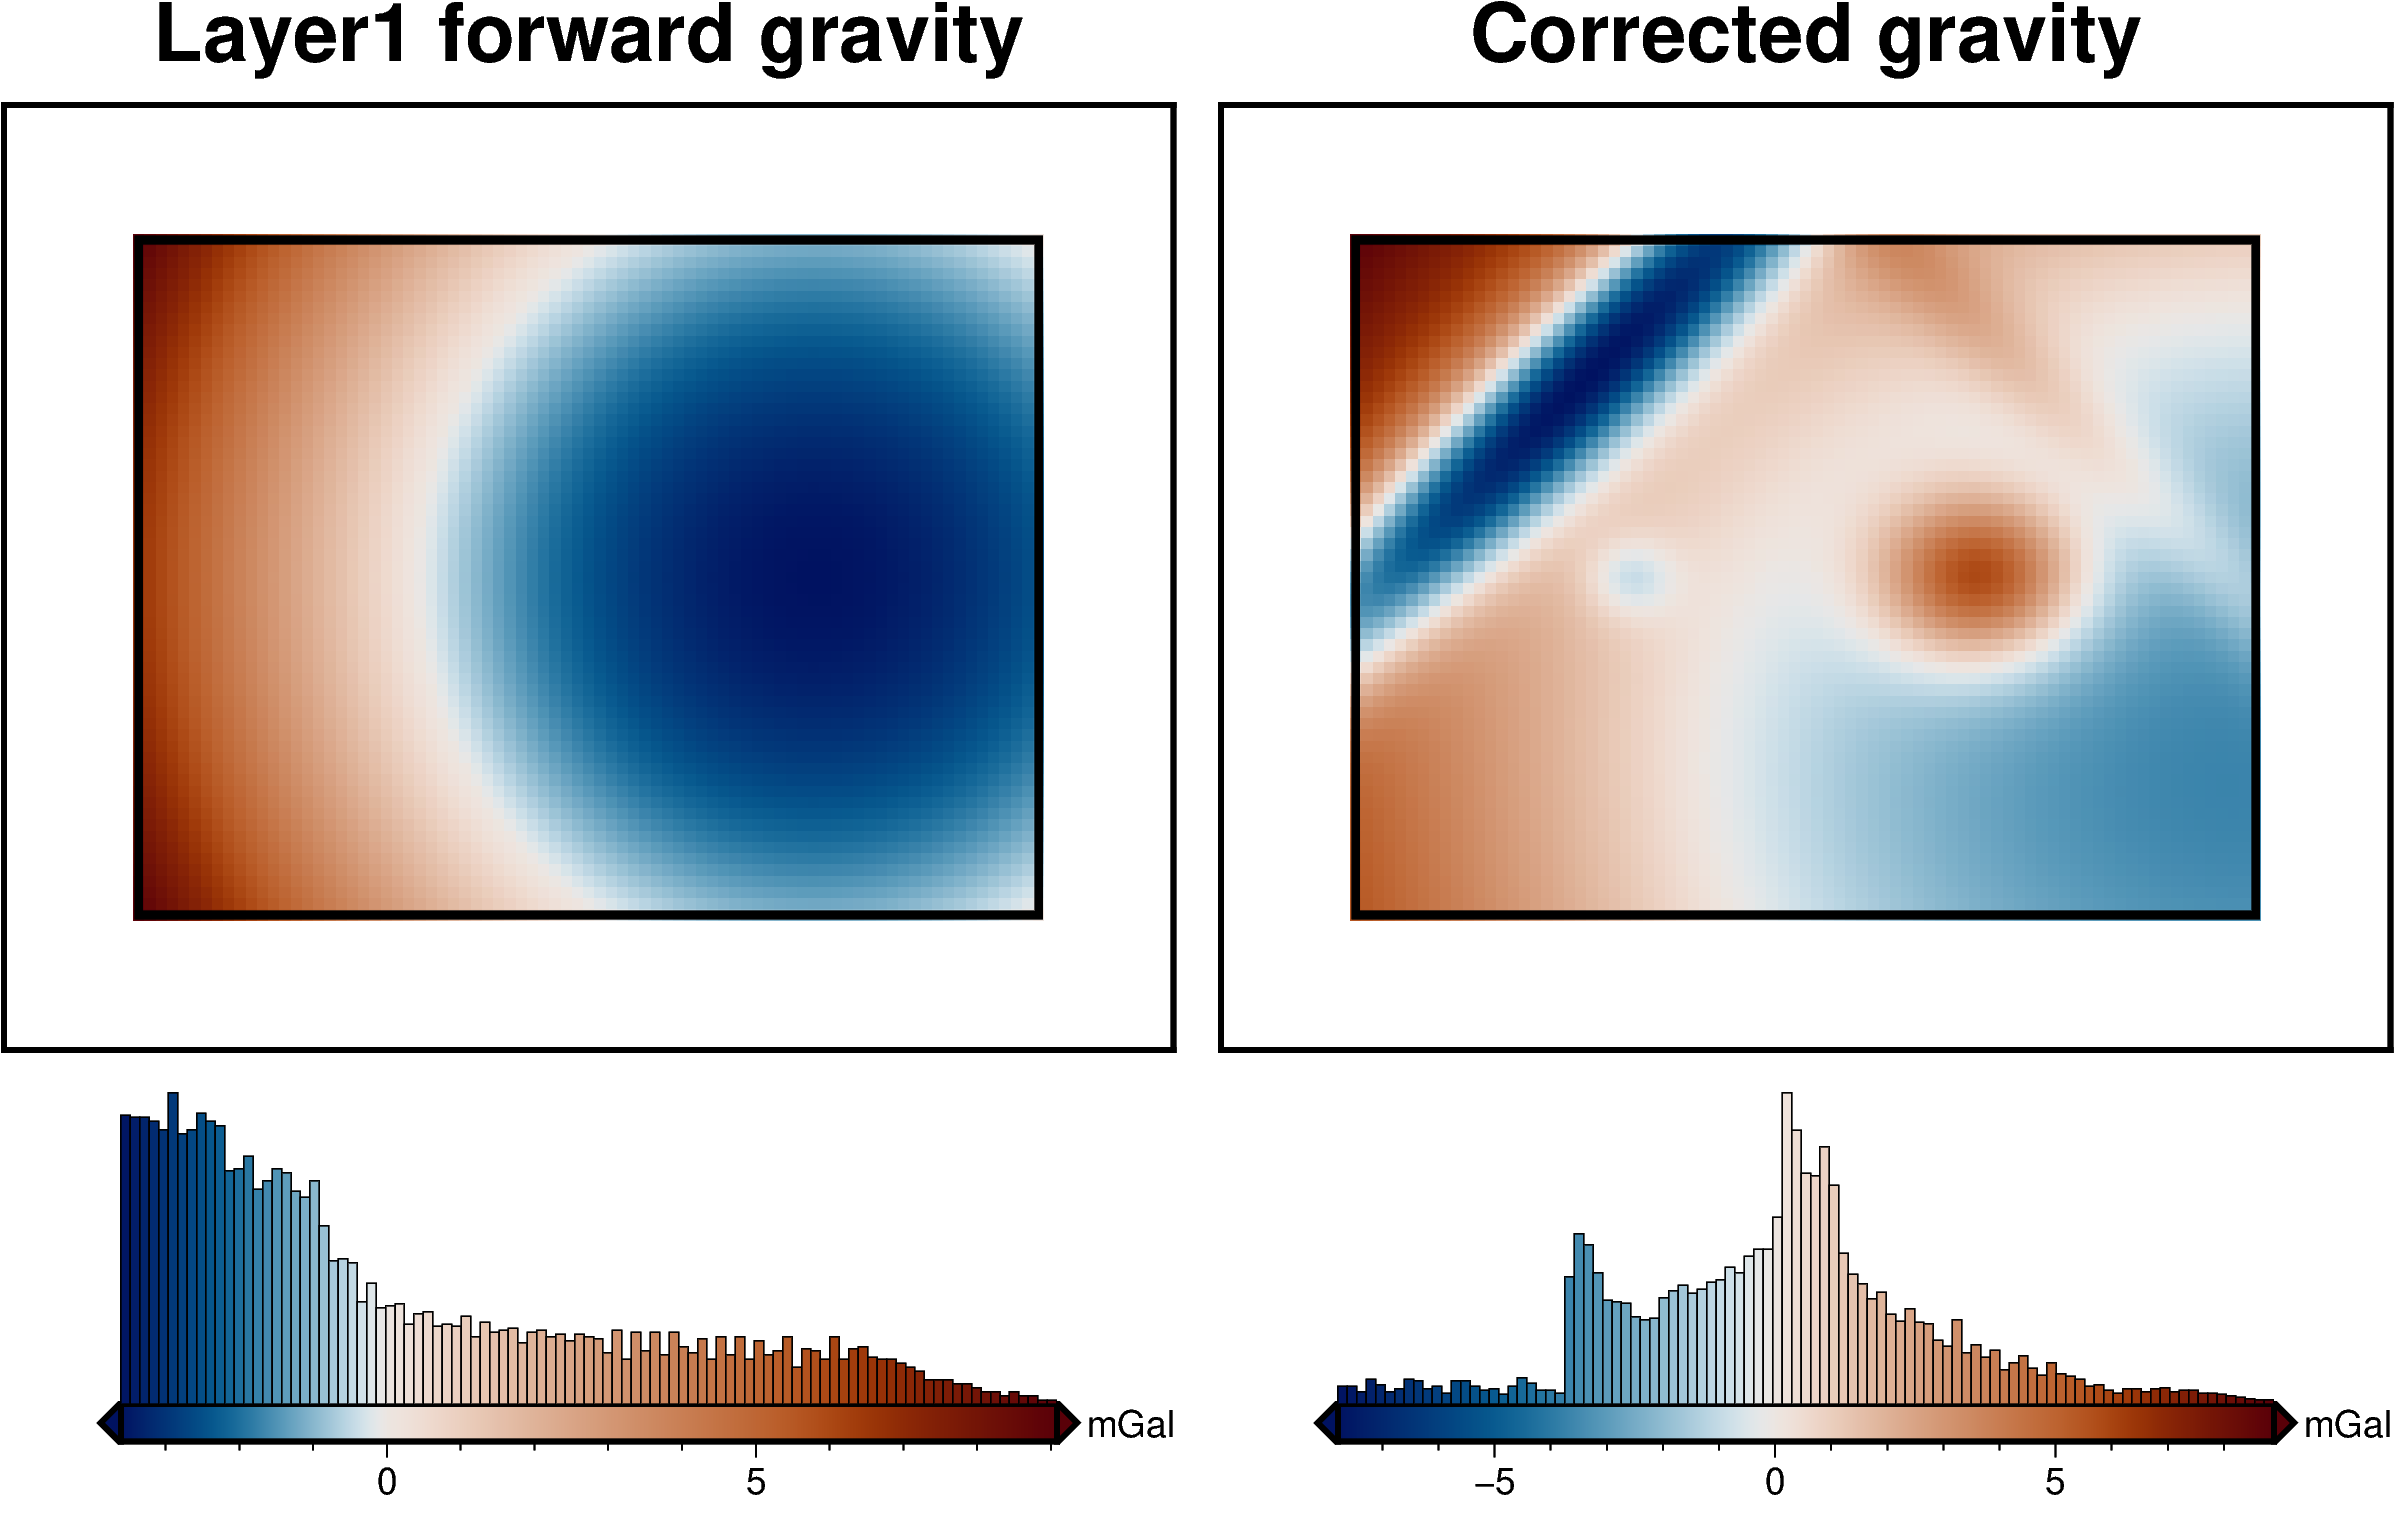

In [10]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title='Layer1 forward gravity',
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)

# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution Layer 2 density contrast. This will be the input into our inversion.


## Bed prisms

In [11]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    top=starting_layer2,
    bottom=starting_layer2.values.mean(),
    density=xr.where(starting_layer2>=starting_layer2.values.mean(), 2300-917, -(2300-917)),
)

plots.show_prism_layers(
    [layer2_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    zscale=100,
    clip_box=False,
    log_scale=False,
)

/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:41: PyVistaDeprecationWarning: `ipyvtklink` backend is deprecated and has been replaced by the `trame` backend.
  warnings.warn(


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## bed gravity

In [12]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav,
    names=['layer2_prisms'],
    remove_mean=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav['layer2_forward'] = layer2_df.forward_total
grav

  0%|          | 0/4941 [00:00<?, ?it/s]

,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward
0,0.0,0.0,14.568305,1000.0,9.079567,5.488738,5.728250
1,1000.0,0.0,14.080812,1000.0,8.764314,5.316498,5.699670
2,2000.0,0.0,13.592559,1000.0,8.450560,5.141999,5.656611
3,3000.0,0.0,13.105121,1000.0,8.139163,4.965958,5.598543
4,4000.0,0.0,12.619702,1000.0,7.830770,4.788932,5.525915
...,...,...,...,...,...,...,...
4936,76000.0,60000.0,0.762734,1000.0,-0.331436,1.094169,-3.435989
4937,77000.0,60000.0,0.839472,1000.0,-0.239442,1.078913,-3.460531
4938,78000.0,60000.0,0.924361,1000.0,-0.142035,1.066397,-3.485066
4939,79000.0,60000.0,1.017314,1000.0,-0.039275,1.056589,-3.508899


returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


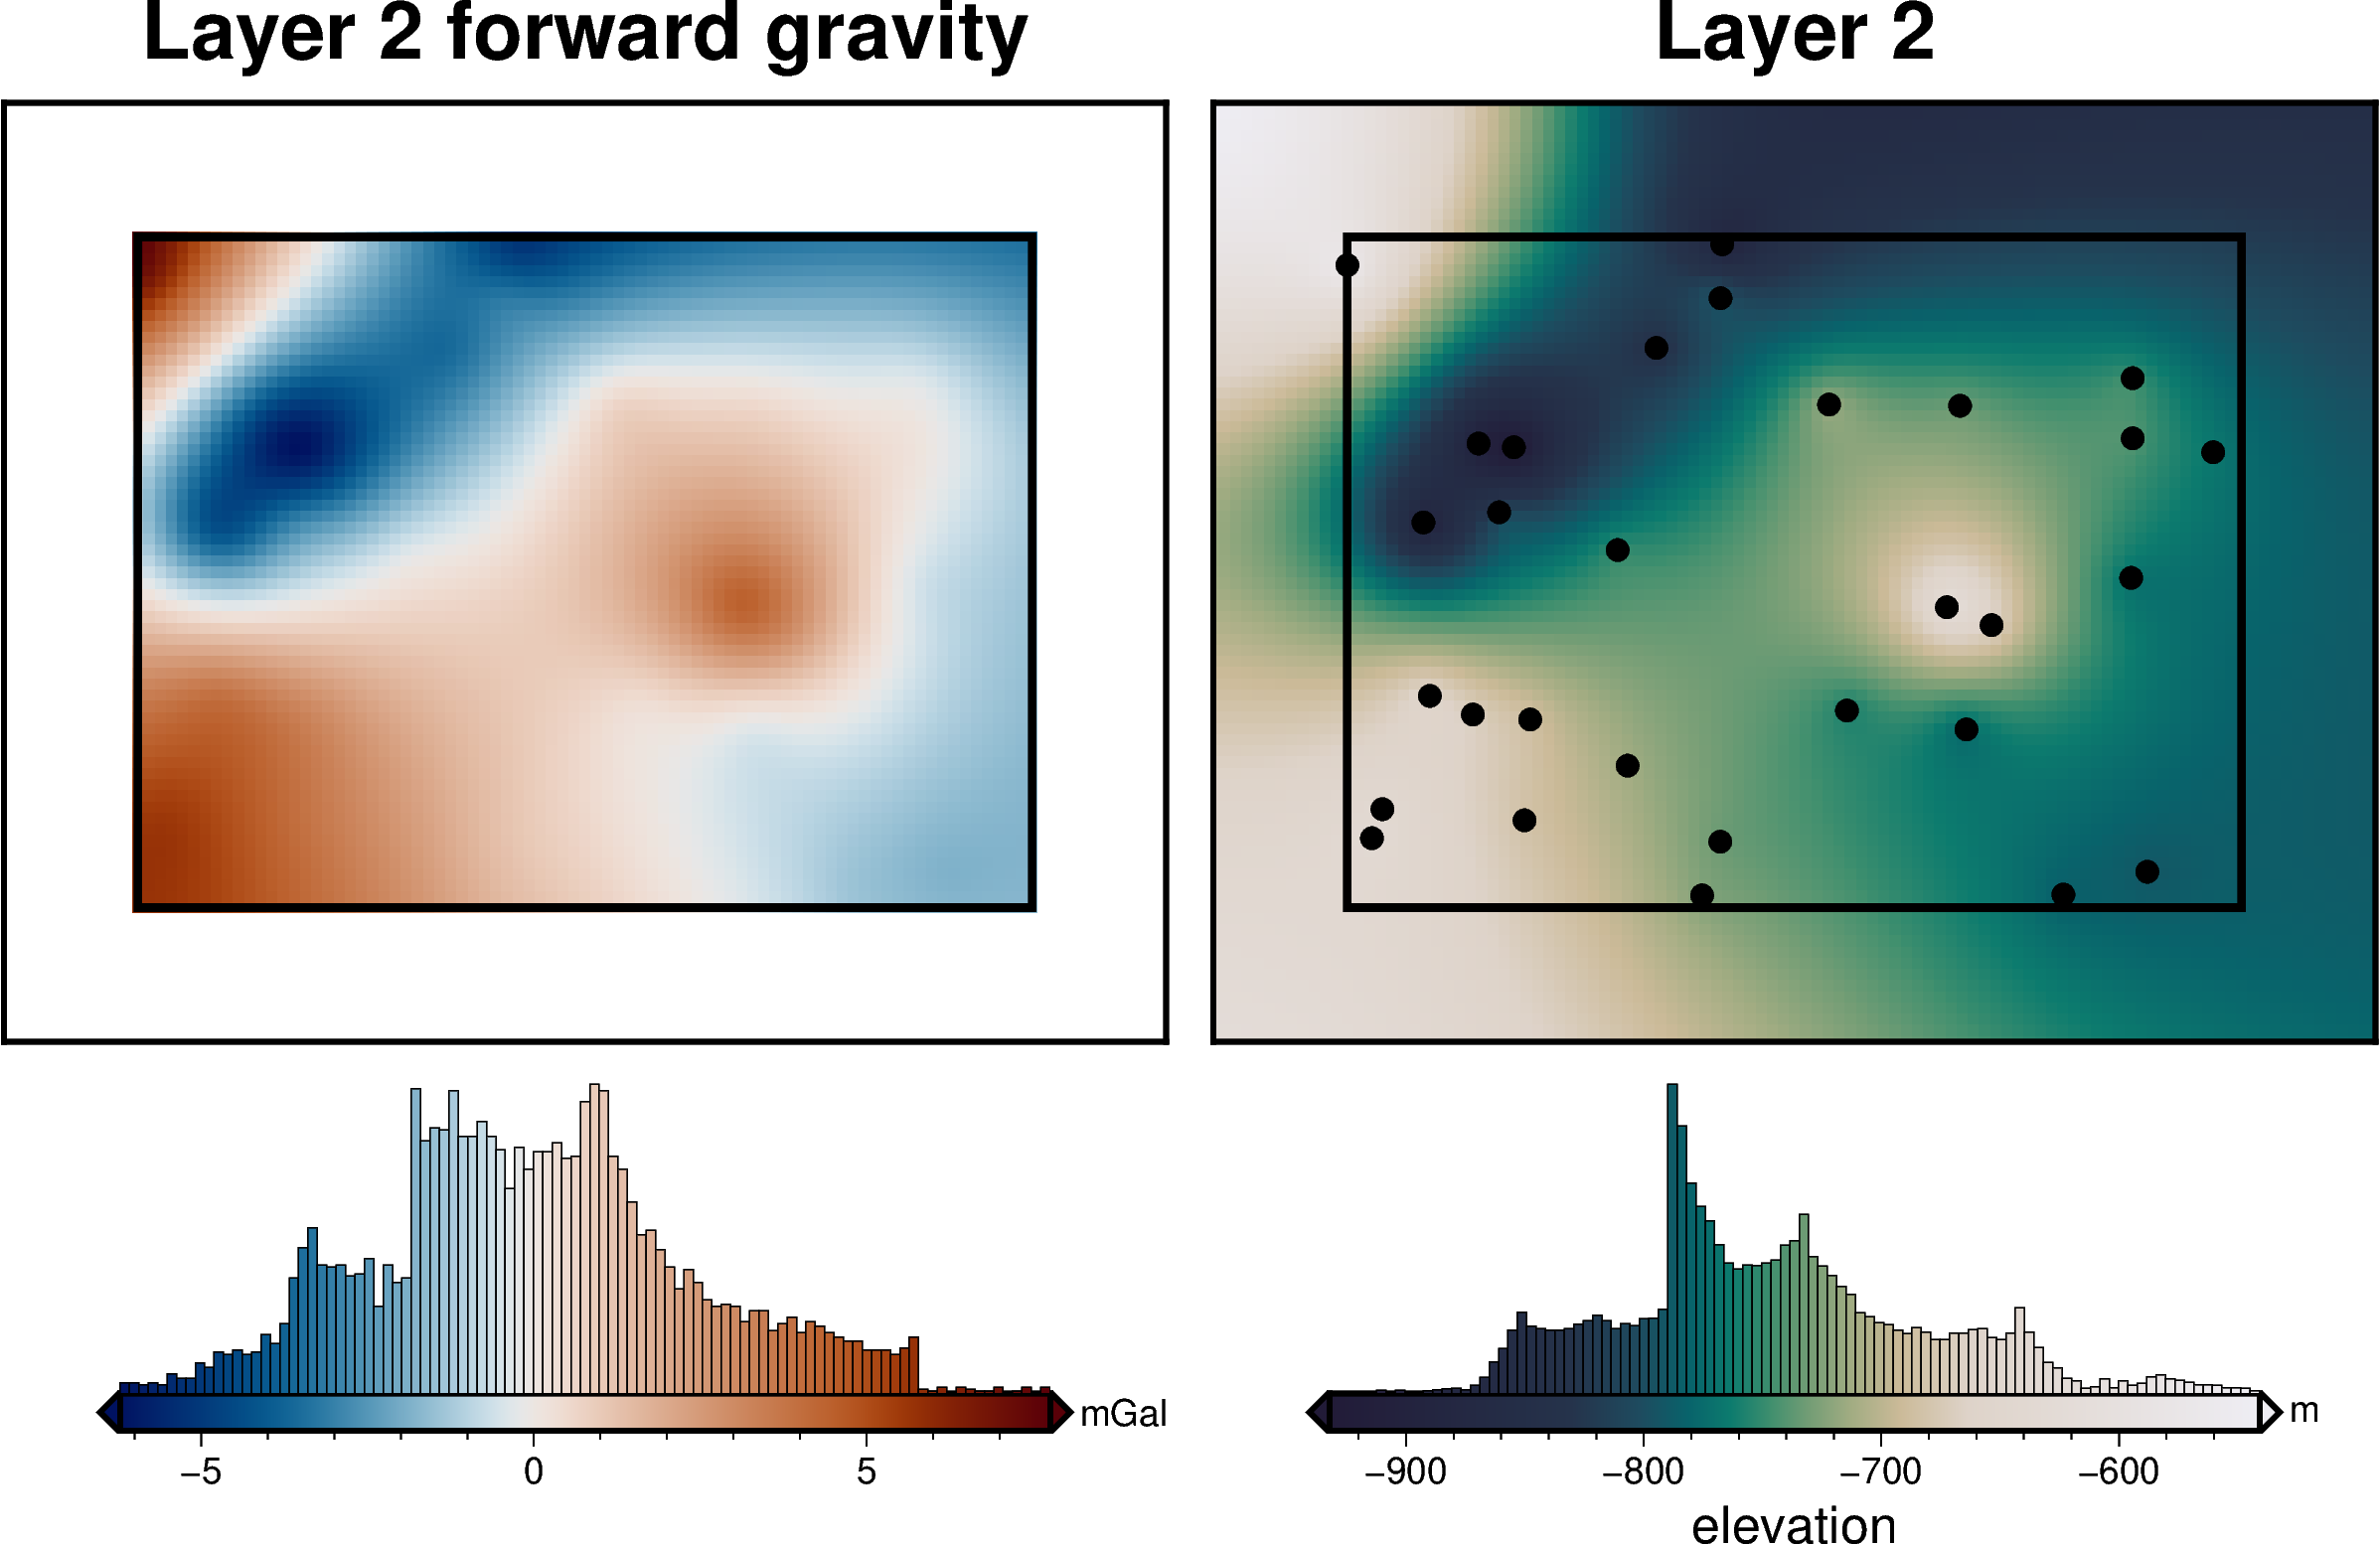

In [13]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Layer 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)

# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Layer 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
)
fig.show()

## calculate misfit

returning original grid
returning original grid


,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward,misfit
0,0.0,0.0,14.568305,1000.0,9.079567,5.488738,5.728250,-0.239512
1,1000.0,0.0,14.080812,1000.0,8.764314,5.316498,5.699670,-0.383173
2,2000.0,0.0,13.592559,1000.0,8.450560,5.141999,5.656611,-0.514612
3,3000.0,0.0,13.105121,1000.0,8.139163,4.965958,5.598543,-0.632585
4,4000.0,0.0,12.619702,1000.0,7.830770,4.788932,5.525915,-0.736983
...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,0.762734,1000.0,-0.331436,1.094169,-3.435989,4.530158
4937,77000.0,60000.0,0.839472,1000.0,-0.239442,1.078913,-3.460531,4.539444
4938,78000.0,60000.0,0.924361,1000.0,-0.142035,1.066397,-3.485066,4.551463
4939,79000.0,60000.0,1.017314,1000.0,-0.039275,1.056589,-3.508899,4.565488


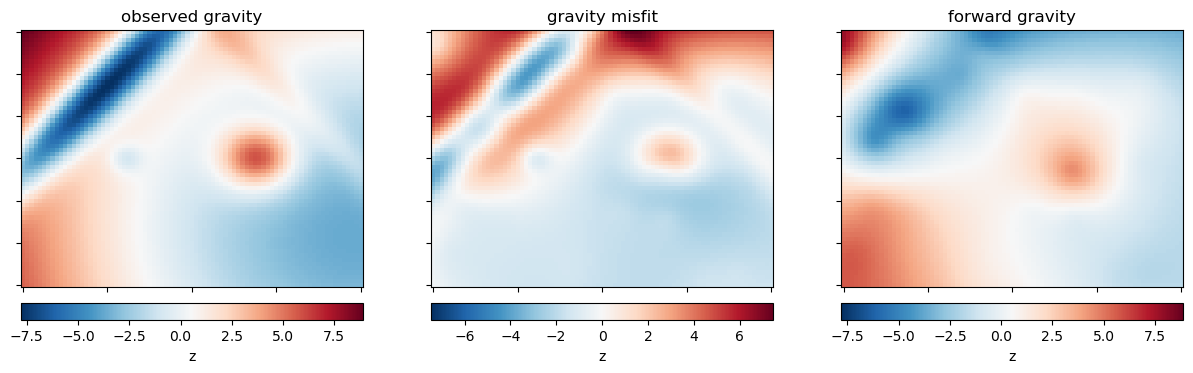

In [14]:
df_misfit = inv.misfit(
    input_grav = grav,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=grav_spacing,
    # plot=False,
    # plot_type='pygmt',
)
df_misfit

In [15]:
df_misfit['reg']=0
df_misfit['res']=df_misfit.misfit
df_misfit

,x,y,Gobs,z,layer1_forward,Gobs_corr,layer2_forward,misfit,reg,res
0,0.0,0.0,14.568305,1000.0,9.079567,5.488738,5.728250,-0.239512,0,-0.239512
1,1000.0,0.0,14.080812,1000.0,8.764314,5.316498,5.699670,-0.383173,0,-0.383173
2,2000.0,0.0,13.592559,1000.0,8.450560,5.141999,5.656611,-0.514612,0,-0.514612
3,3000.0,0.0,13.105121,1000.0,8.139163,4.965958,5.598543,-0.632585,0,-0.632585
4,4000.0,0.0,12.619702,1000.0,7.830770,4.788932,5.525915,-0.736983,0,-0.736983
...,...,...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,0.762734,1000.0,-0.331436,1.094169,-3.435989,4.530158,0,4.530158
4937,77000.0,60000.0,0.839472,1000.0,-0.239442,1.078913,-3.460531,4.539444,0,4.539444
4938,78000.0,60000.0,0.924361,1000.0,-0.142035,1.066397,-3.485066,4.551463,0,4.551463
4939,79000.0,60000.0,1.017314,1000.0,-0.039275,1.056589,-3.508899,4.565488,0,4.565488


# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

In [16]:
prism_results, grav_results = inv.geo_inversion_dens_contrast(
    input_grav=df_misfit,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    layer=starting_layer2,
    density_contrast=(2300-917),
    max_iterations=10,
    # optional
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.02,
    # upper_confining_layer=layer1,
    # deriv_type = "annulus", 
    deriv_type = "prisms", # default
    # jacobian_prism_size = 1,
    solver_type = "verde least squares", # default
    # solver_type = "scipy conjugate",
    # solver_type = "numpy least squares",
    # solver_type = "scipy least squares",
    # solver_type = "steepest descent",
    # solver_type = "gauss newton",
    # solver_damping = 1000,
    max_layer_change_per_iter = 50,

    # kwargs
    # registration="g",
)


##############################################################################################
iteration 1


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 46 m, RMSE:1049 m
Layer correction (after clipped) mean: -1m, RMSE:38 m

updated misfit RMSE: 1.35
updated L2-norm: 1.16,  tolerance: 0.5
updated delta L2-norm : 1.27,  tolerance: 1.02

##############################################################################################
iteration 2


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 39 m, RMSE:675 m
Layer correction (after clipped) mean: -2m, RMSE:30 m

updated misfit RMSE: 0.91
updated L2-norm: 0.95,  tolerance: 0.5
updated delta L2-norm : 1.22,  tolerance: 1.02

##############################################################################################
iteration 3


/home/matt/mambaforge/envs/RIS_gravity_inversion/lib/python3.9/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


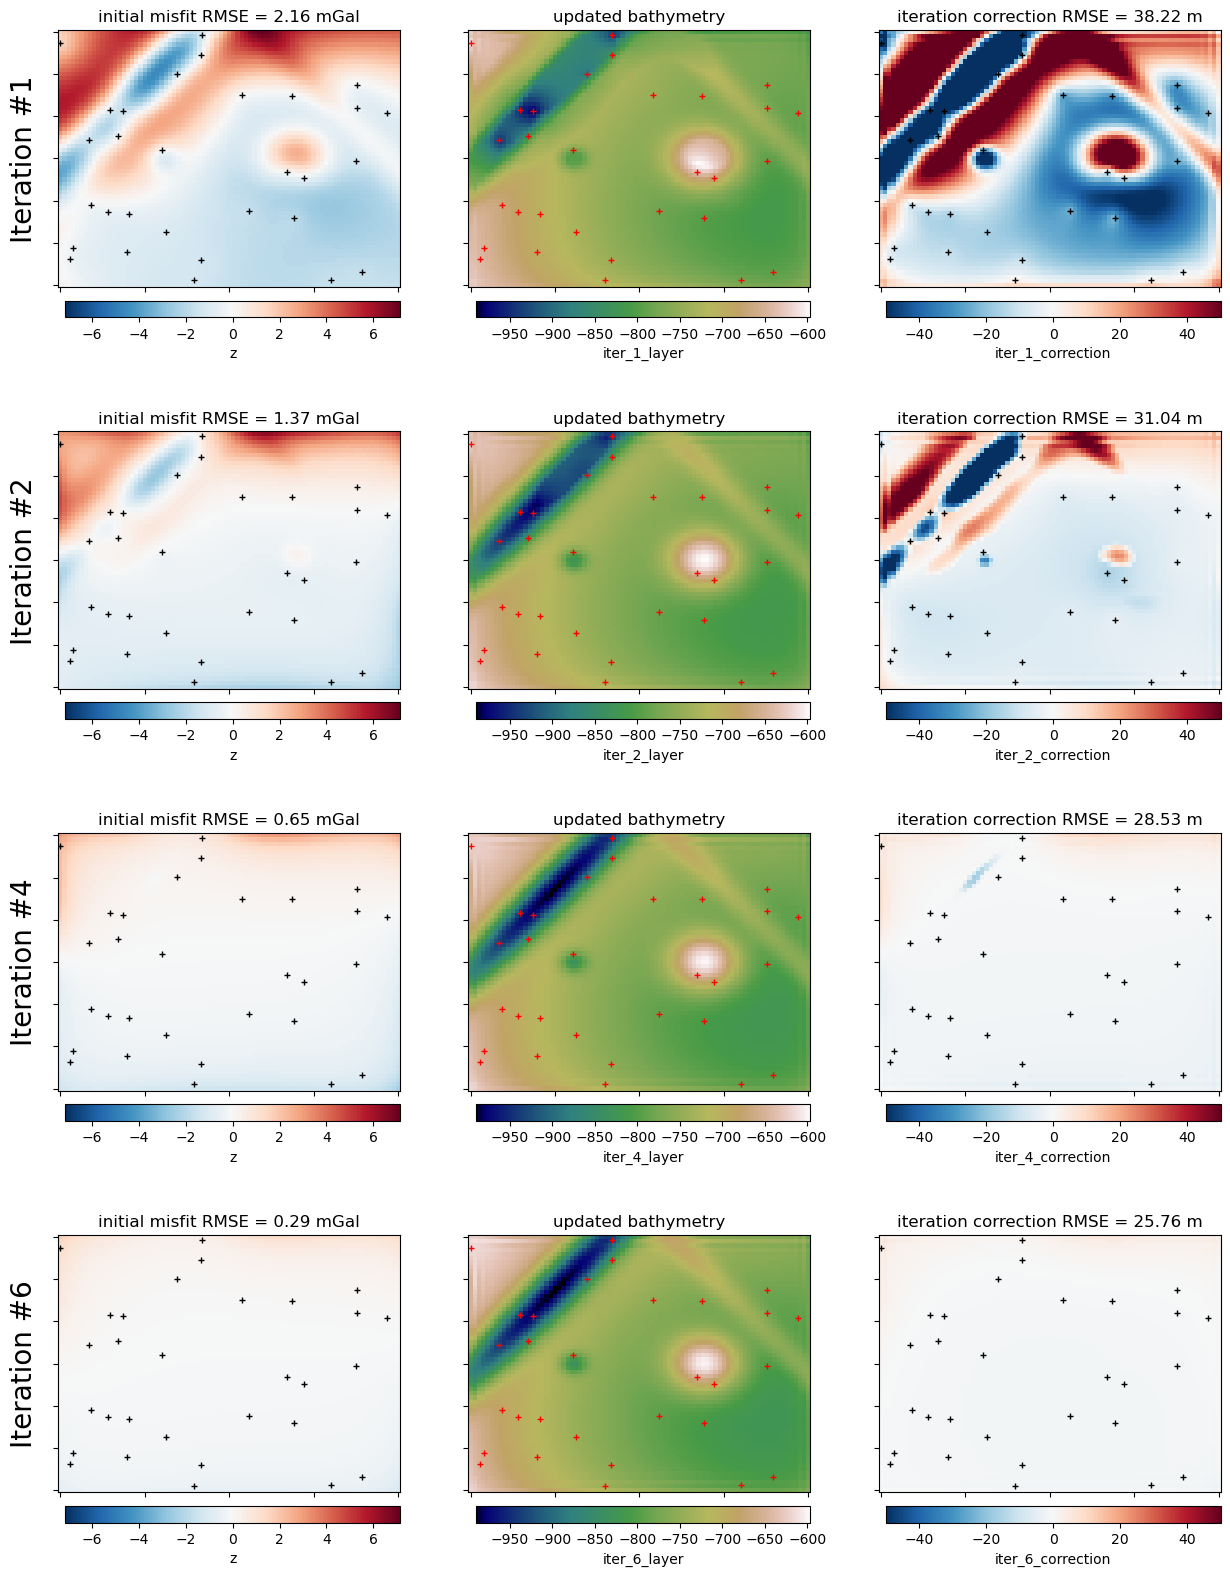

In [ ]:
grids = plots.plot_inversion_results(
    grav_results,
    prism_results, 
    grav_region=inversion_region,
    grav_spacing=grav_spacing,
    constraints=constraint_points,
    plot_topo_results=False,
    plot_grav_results=False,
    iters_to_plot=4,
    )

# Compare
## compare inverted Layer2 to true Layer2

In [ ]:
ds = prism_results.rename(columns={'easting':'x', 'northing':'y'}).set_index(['y', 'x']).to_xarray()

ds_inner = ds.sel(
    x=slice(inversion_region[0], inversion_region[1]),
    y=slice(inversion_region[2], inversion_region[3])
)

cols = [s for s in prism_results.columns.to_list() if "_layer" in s]
for i, j in enumerate(cols, start=1):
    dif = true_layer2 - ds_inner[j]
    RMSE = inv.RMSE(dif)
    print(f"RMSE iter {i}: {round(RMSE, 2)}m")

final_layer2 = ds_inner[cols[-1]]

RMSE iter 1: 73.1m
RMSE iter 2: 47.4m
RMSE iter 3: 38.31m
RMSE iter 4: 36.51m
RMSE iter 5: 36.47m
RMSE iter 6: 36.73m
RMSE iter 7: 37.15m


returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


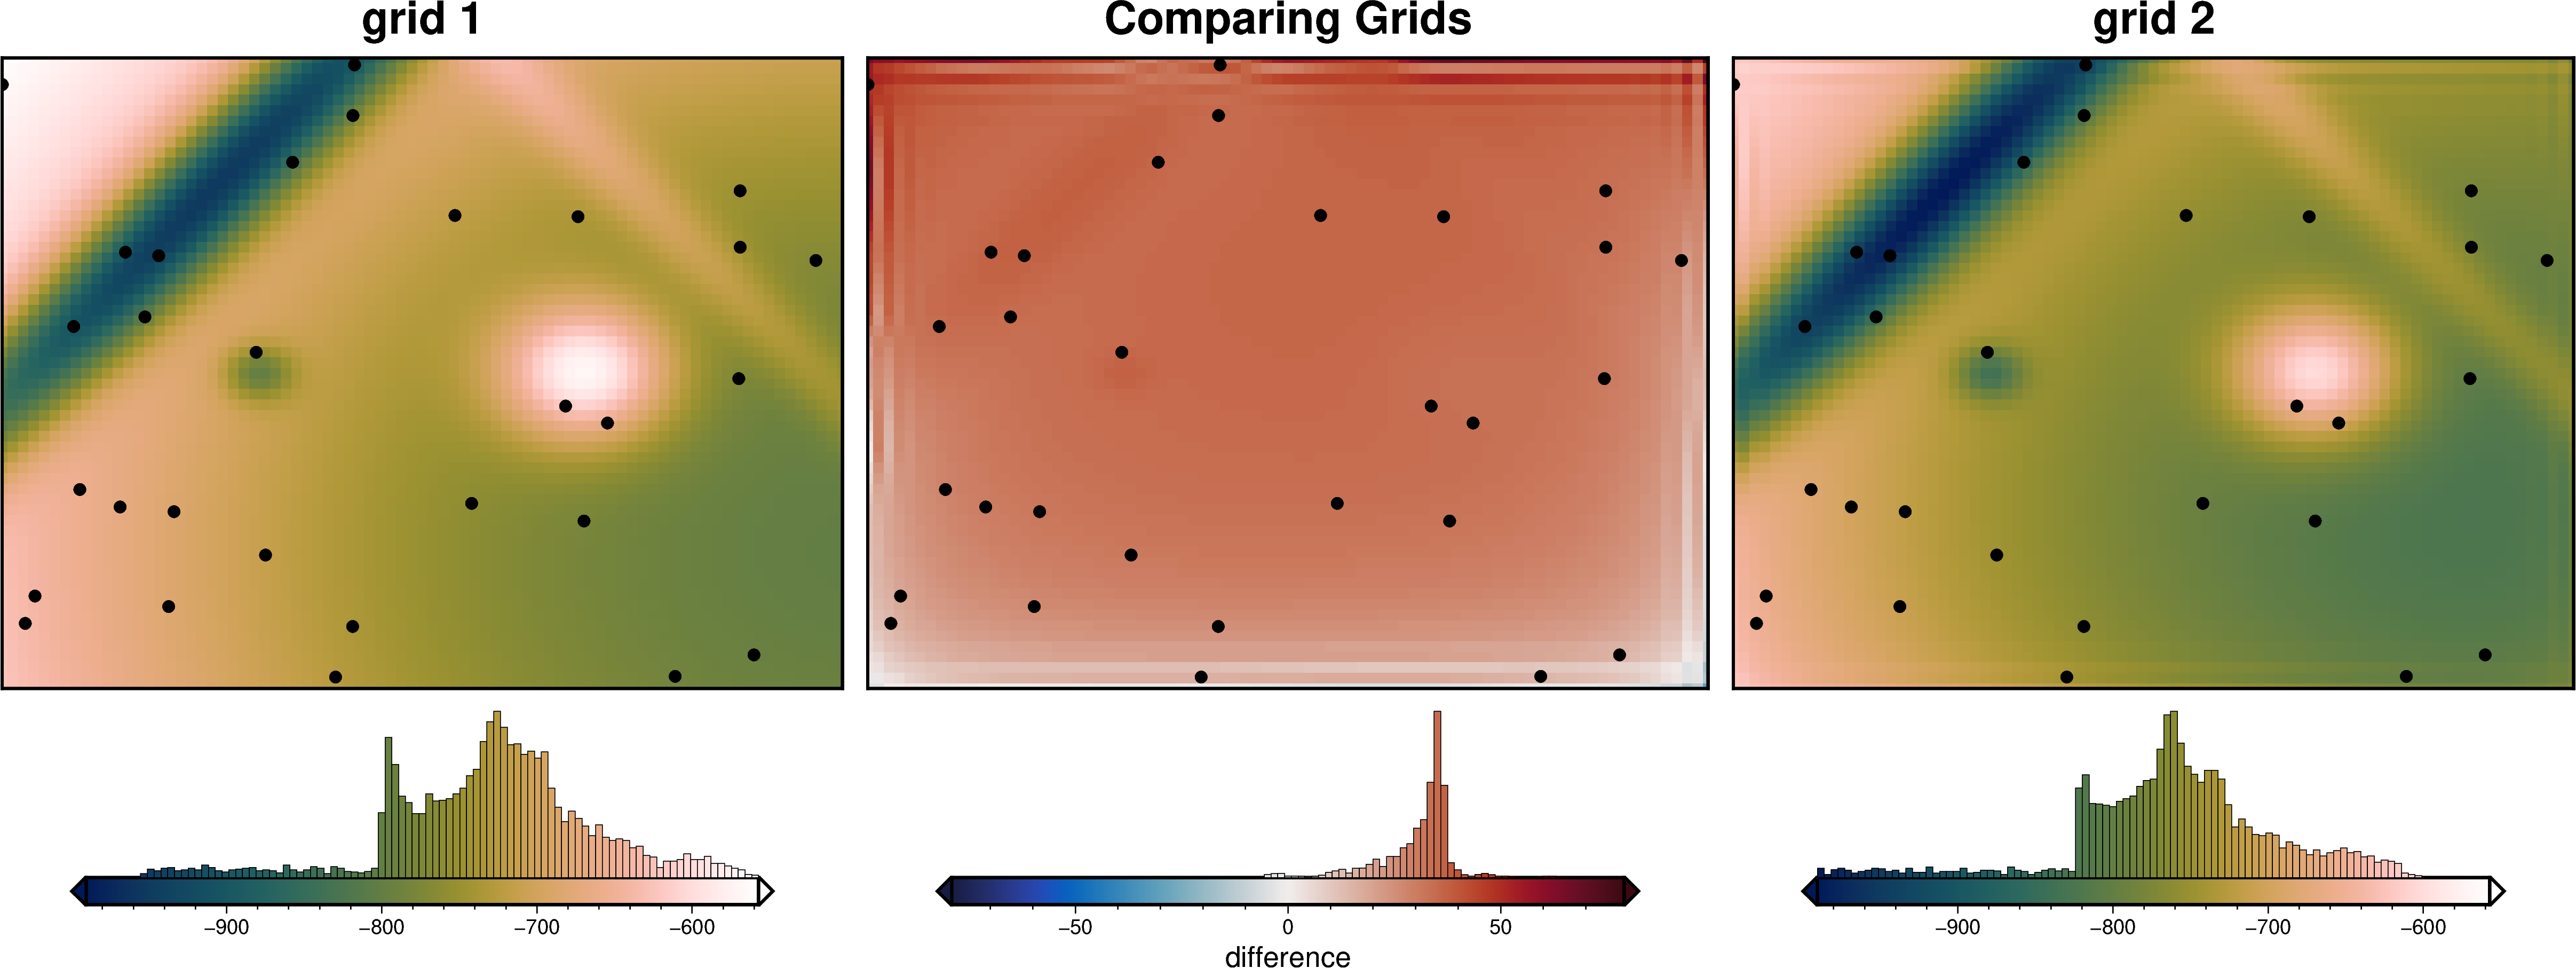

In [ ]:
grids = utils.grd_compare(
    true_layer2,
    final_layer2,
    grid1_name='True layer 2',
    grid2_name='Final layer 2',
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    cmap='batlowW',
    # cmap="gist_earth",
    robust=True,
    points=constraint_points,
    hist=True,
    inset=False,
)

## compare inverted Layer2 to starting low-res Layer2

returning original grid
returning original grid


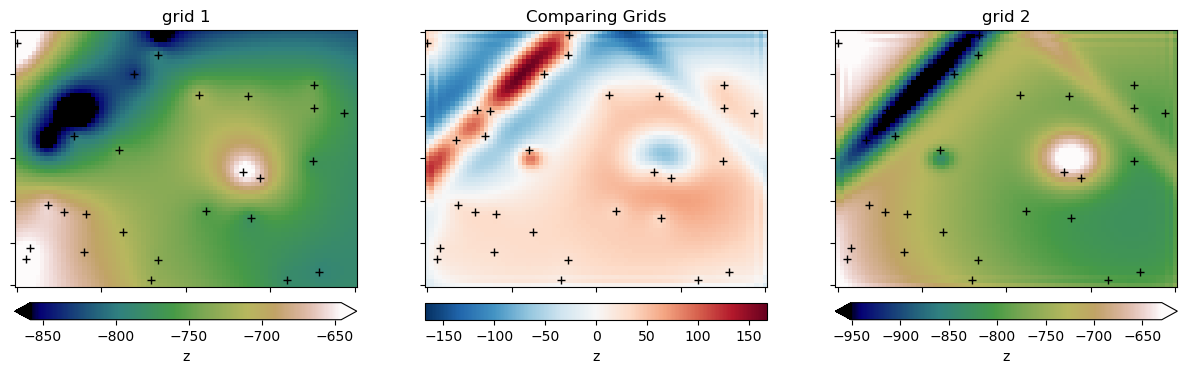

In [ ]:
grids = utils.grd_compare(
    starting_layer2,
    final_layer2,
    grid1_name='Starting layer 2',
    grid2_name='Final layer 2',
    region=inversion_region,
    plot=True,
    plot_type="xarray",
    cmap="gist_earth",
    robust=True,
    points=constraint_points,
)

## compare observed gravity to forward
compare the true oberseved gravity (forward grav of full res layer 1 and 2) with the forward gravity from the inversion results.

In [ ]:
# load the true forward gravity of both layers
true_forward_total = fetch.resample_grid(
    synthetic_gravity.forward_total,
    region=inversion_region,
    spacing=grav_spacing,
    registration=registration,
)

returning original grid


In [ ]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    top=layer1,
    bottom=layer1.values.mean(),
    density=xr.where(layer1>=layer1.values.mean(), 917, -917),
)

# create prisms around inverted Layer 2
# positive densities above reference, negative below
inverted_layer2_prisms = inv_utils.grids_to_prisms(
    top=final_layer2,
    bottom=final_layer2.values.mean(),
    density=xr.where(final_layer2>=final_layer2.values.mean(), 2300-917, -(2300-917)),
)

# calculate gravity
final_forward, final_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms, inverted_layer2_prisms],
    grav,
    names=['layer1_forward','final_layer2_forward'],
    remove_mean=True,
    progressbar=True,
    plot=False,
)

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


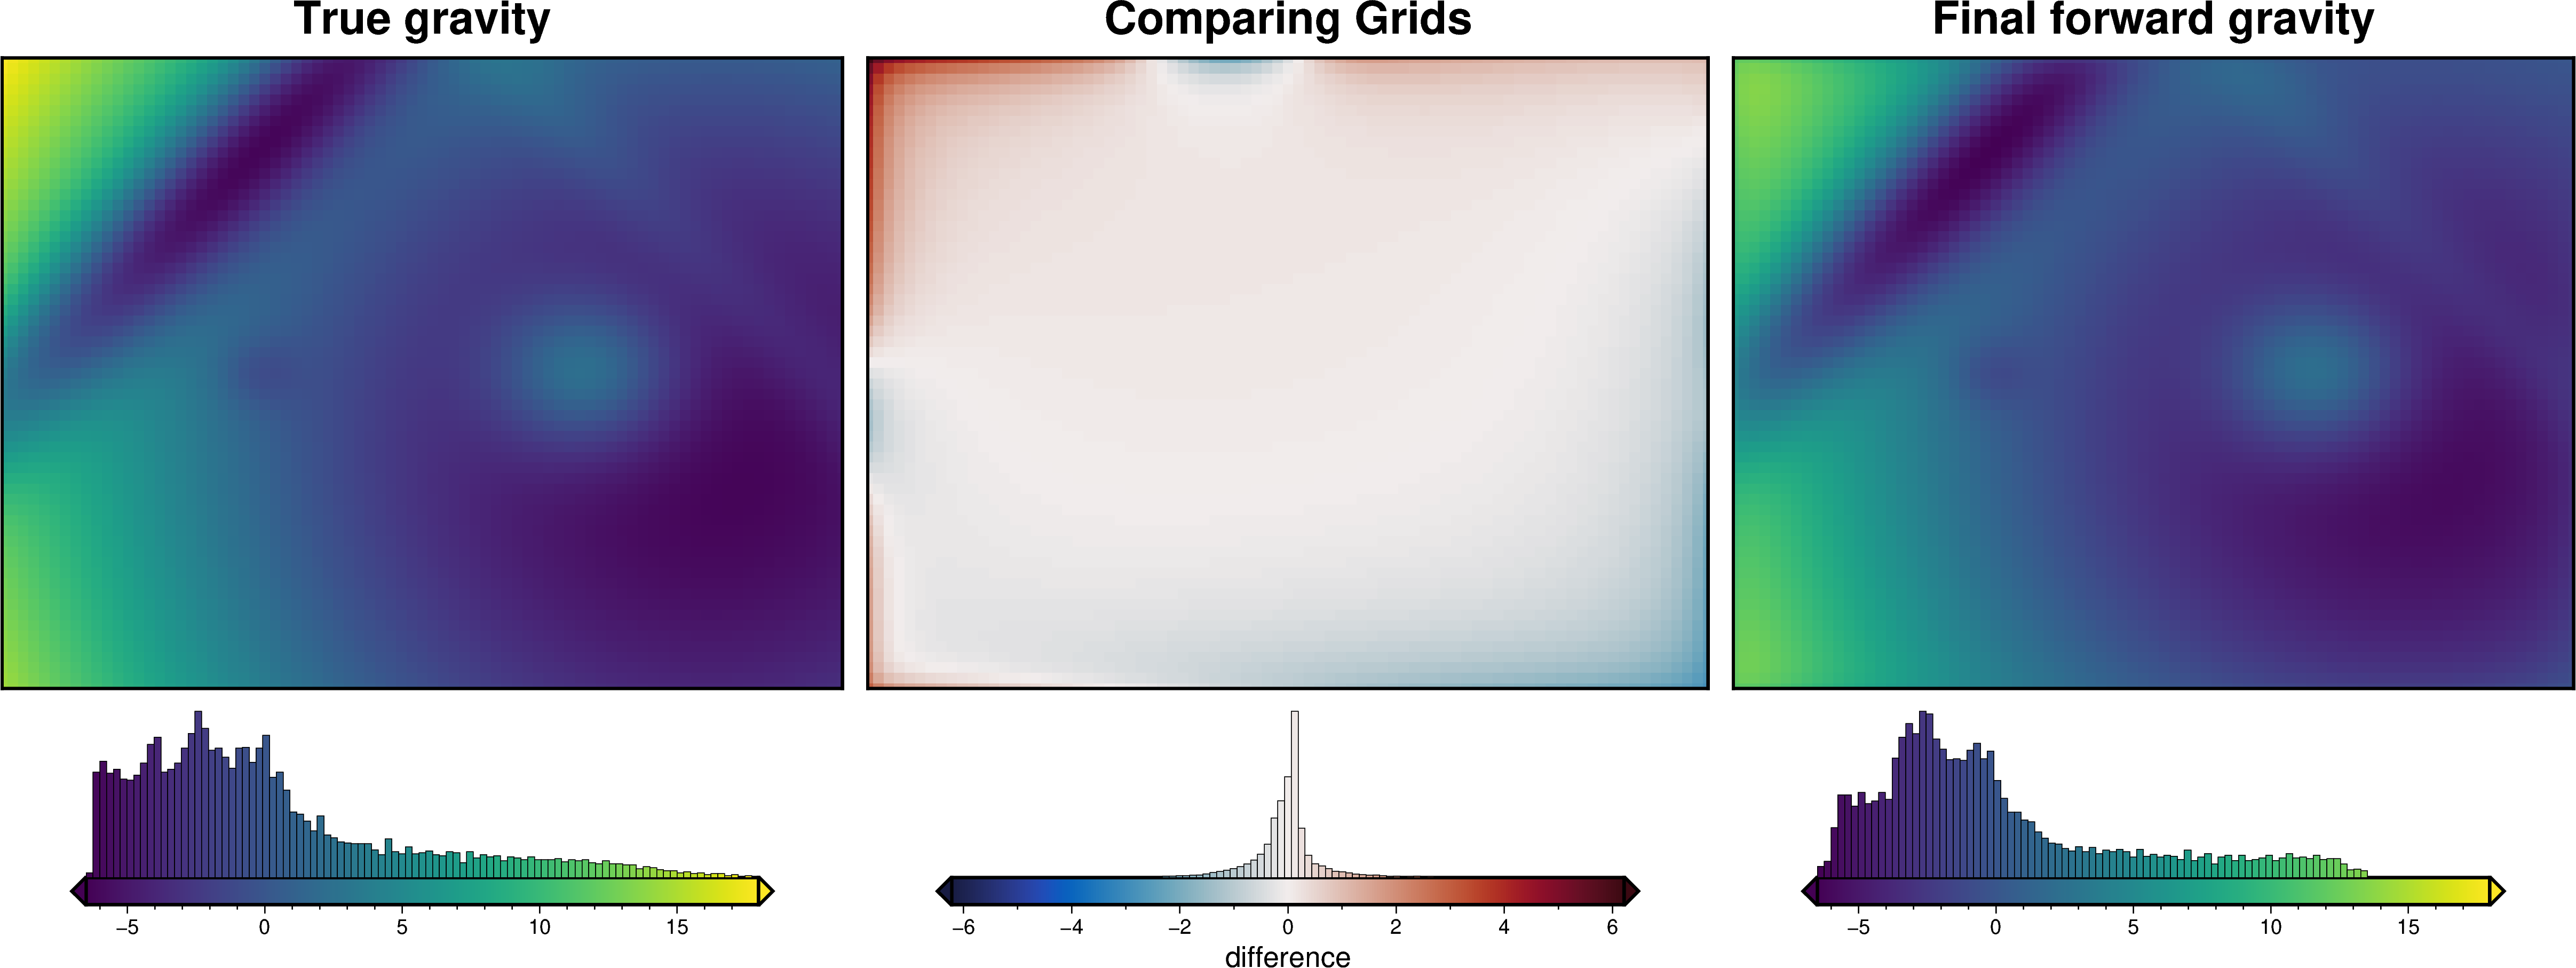

In [ ]:
grids = utils.grd_compare(
    true_forward_total,
    final_forward.forward_total,
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    grid1_name='True gravity',
    grid2_name='Final forward gravity',
    robust=True,
    hist=True,
    inset=False,
)

# Repeate with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [ ]:
df_misfit['res'] = synth.contaminate(
    df_misfit.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_misfit

,x,y,Gobs,z,layer1_prisms,forward_total,layer1_forward,Gobs_corr,layer2_prisms,layer2_forward,misfit,reg,res,final_layer2_forward
0,0.0,0.0,14.568305,1000.0,9.079567,11.578264,9.079567,5.488738,5.260215,5.260215,0.228523,0,0.483099,2.498696
1,1000.0,0.0,14.080812,1000.0,8.764314,11.846815,8.764314,5.316498,5.233971,5.233971,0.082527,0,0.142235,3.082501
2,2000.0,0.0,13.592559,1000.0,8.450560,11.766586,8.450560,5.141999,5.194429,5.194429,-0.052431,0,0.089943,3.316026
3,3000.0,0.0,13.105121,1000.0,8.139163,11.513582,8.139163,4.965958,5.141106,5.141106,-0.175148,0,0.147558,3.374419
4,4000.0,0.0,12.619702,1000.0,7.830770,11.184604,7.830770,4.788932,5.074412,5.074412,-0.285481,0,-0.016116,3.353834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,76000.0,60000.0,0.762734,1000.0,-0.331436,-0.234315,-0.331436,1.094169,-3.155246,-3.155246,4.249416,0,4.201988,0.097121
4937,77000.0,60000.0,0.839472,1000.0,-0.239442,-0.164708,-0.239442,1.078913,-3.177783,-3.177783,4.256697,0,4.163396,0.074734
4938,78000.0,60000.0,0.924361,1000.0,-0.142035,-0.093104,-0.142035,1.066397,-3.200313,-3.200313,4.266710,0,4.132572,0.048932
4939,79000.0,60000.0,1.017314,1000.0,-0.039275,-0.015090,-0.039275,1.056589,-3.222199,-3.222199,4.278789,0,4.366755,0.024185


In [ ]:
prism_results, grav_results = inv.geo_inversion_dens_contrast(
    input_grav=df_misfit,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    layer=starting_layer2,
    density_contrast=(2300-917),
    max_iterations=10,
    # optional
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=0.06,
    # upper_confining_layer=layer1,
    # deriv_type = "annulus", 
    deriv_type = "prisms", # default
    # jacobian_prism_size = 1,
    solver_type = "verde least squares", # default
    # solver_type = "scipy conjugate",
    # solver_type = "numpy least squares",
    # solver_type = "scipy least squares",
    # solver_type = "steepest descent",
    # solver_type = "gauss newton",
    # solver_damping = 1000,
    max_layer_change_per_iter = 50,

    # kwargs
    # registration="g",
)


##############################################################################################
iteration 1


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 63 m, RMSE:1200 m
Layer correction (after clipped) mean: 0m, RMSE:48 m

updated misfit RMSE: 2.18
updated L2-norm: 1.48,  tolerance: 0.5
updated delta L2-norm : 1.0,  tolerance: 0.06

##############################################################################################
iteration 2


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 121 m, RMSE:1104 m
Layer correction (after clipped) mean: -2m, RMSE:42 m

updated misfit RMSE: 1.6
updated L2-norm: 1.27,  tolerance: 0.5
updated delta L2-norm : 1.17,  tolerance: 0.06

##############################################################################################
iteration 3


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 68 m, RMSE:862 m
Layer correction (after clipped) mean: -1m, RMSE:33 m

updated misfit RMSE: 1.09
updated L2-norm: 1.05,  tolerance: 0.5
updated delta L2-norm : 1.21,  tolerance: 0.06

##############################################################################################
iteration 4


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 39 m, RMSE:591 m
Layer correction (after clipped) mean: -1m, RMSE:29 m

updated misfit RMSE: 0.77
updated L2-norm: 0.88,  tolerance: 0.5
updated delta L2-norm : 1.19,  tolerance: 0.06

##############################################################################################
iteration 5


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 27 m, RMSE:419 m
Layer correction (after clipped) mean: -1m, RMSE:28 m

updated misfit RMSE: 0.55
updated L2-norm: 0.74,  tolerance: 0.5
updated delta L2-norm : 1.19,  tolerance: 0.06

##############################################################################################
iteration 6


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 23 m, RMSE:311 m
Layer correction (after clipped) mean: 0m, RMSE:27 m

updated misfit RMSE: 0.37
updated L2-norm: 0.61,  tolerance: 0.5
updated delta L2-norm : 1.22,  tolerance: 0.06

##############################################################################################
iteration 7


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 8925).
  warn(


Layer correction mean: 21 m, RMSE:225 m
Layer correction (after clipped) mean: 0m, RMSE:26 m

updated misfit RMSE: 0.23
updated L2-norm: 0.48,  tolerance: 0.5
updated delta L2-norm : 1.26,  tolerance: 0.06

Inversion terminated after 7 iterations with L2-norm = 0.48 because L2-norm < 0.5


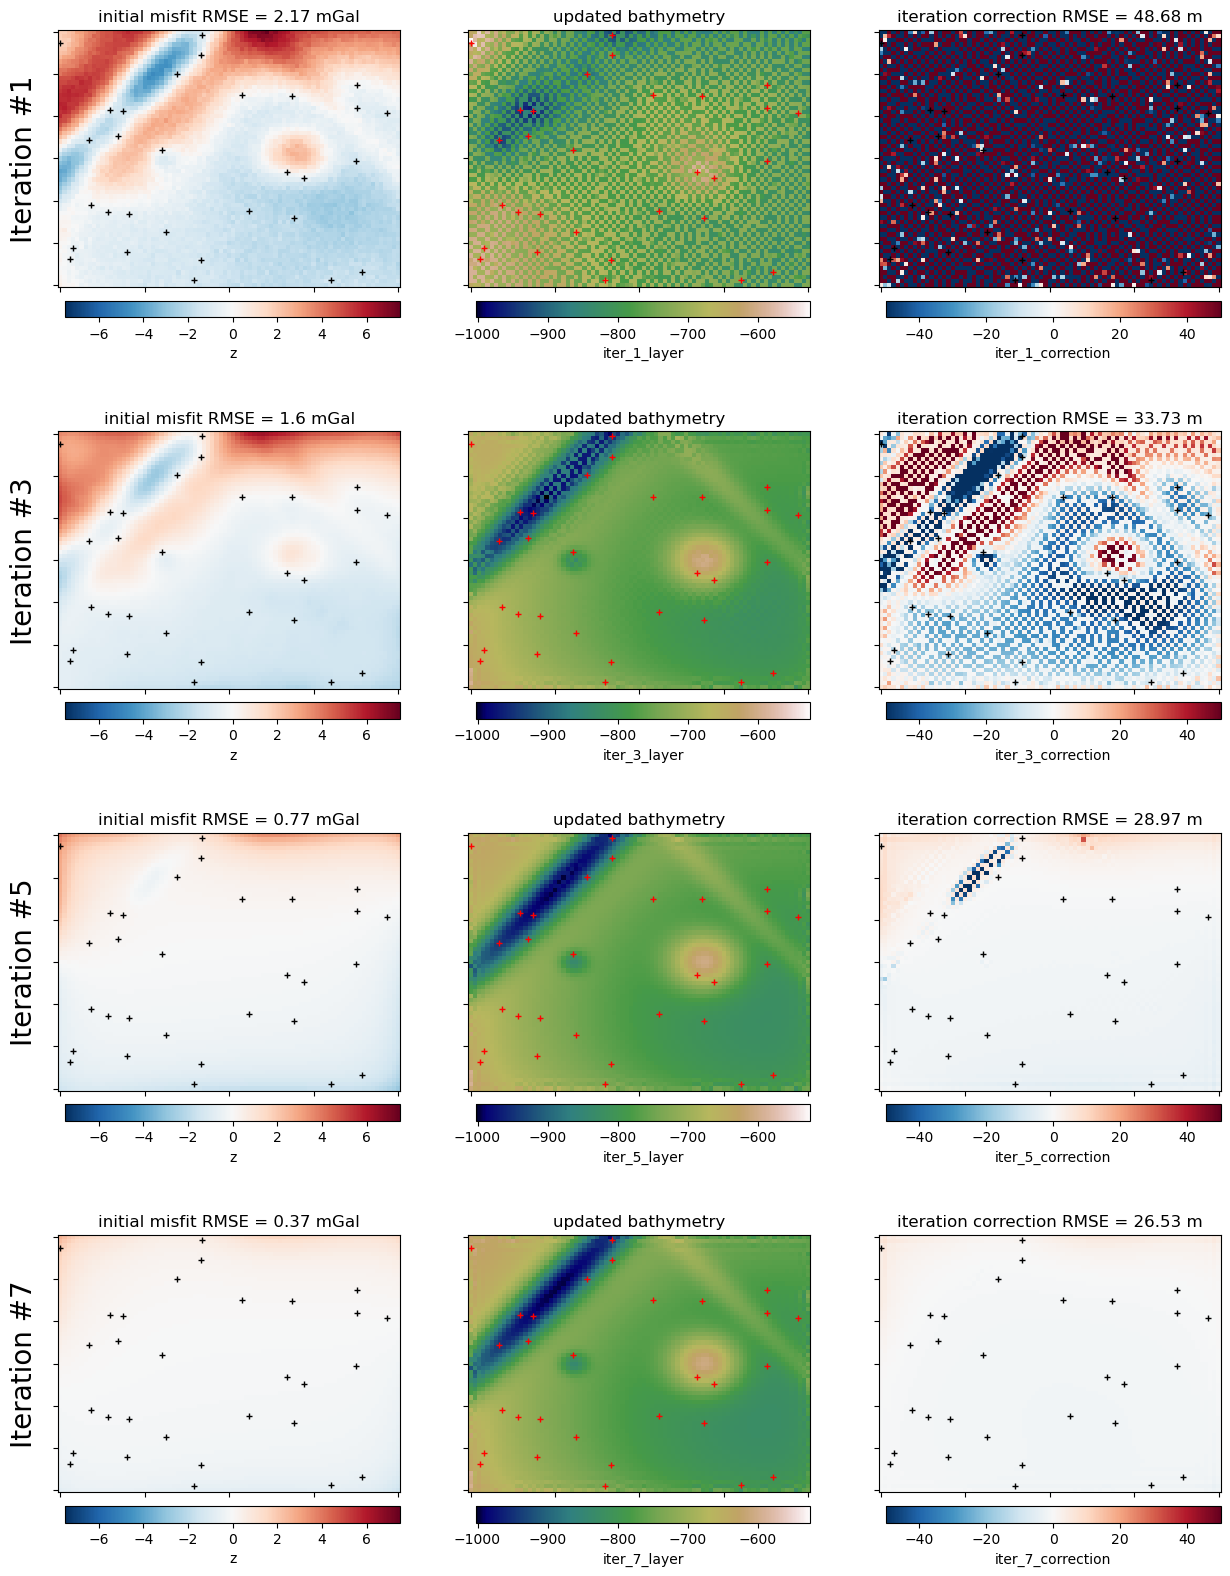

In [ ]:
grids = plots.plot_inversion_results(
    grav_results,
    prism_results, 
    grav_region=inversion_region,
    grav_spacing=grav_spacing,
    constraints=constraint_points,
    plot_topo_results=False,
    plot_grav_results=False,
    iters_to_plot=4,
    )

In [ ]:
ds_noise = prism_results.rename(columns={'easting':'x', 'northing':'y'}).set_index(['y', 'x']).to_xarray()

ds_noise_inner = ds_noise.sel(
    x=slice(inversion_region[0], inversion_region[1]),
    y=slice(inversion_region[2], inversion_region[3])
)

cols = [s for s in prism_results.columns.to_list() if "_layer" in s]
for i, j in enumerate(cols, start=1):
    dif = true_layer2 - ds_noise_inner[j]
    RMSE = inv.RMSE(dif)
    print(f"RMSE iter {i}: {round(RMSE, 2)}m")

final_layer2_noise = ds_noise_inner[cols[-1]]

RMSE iter 1: 73.1m
RMSE iter 2: 47.4m
RMSE iter 3: 38.31m
RMSE iter 4: 36.51m
RMSE iter 5: 36.47m
RMSE iter 6: 36.73m
RMSE iter 7: 37.15m


returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


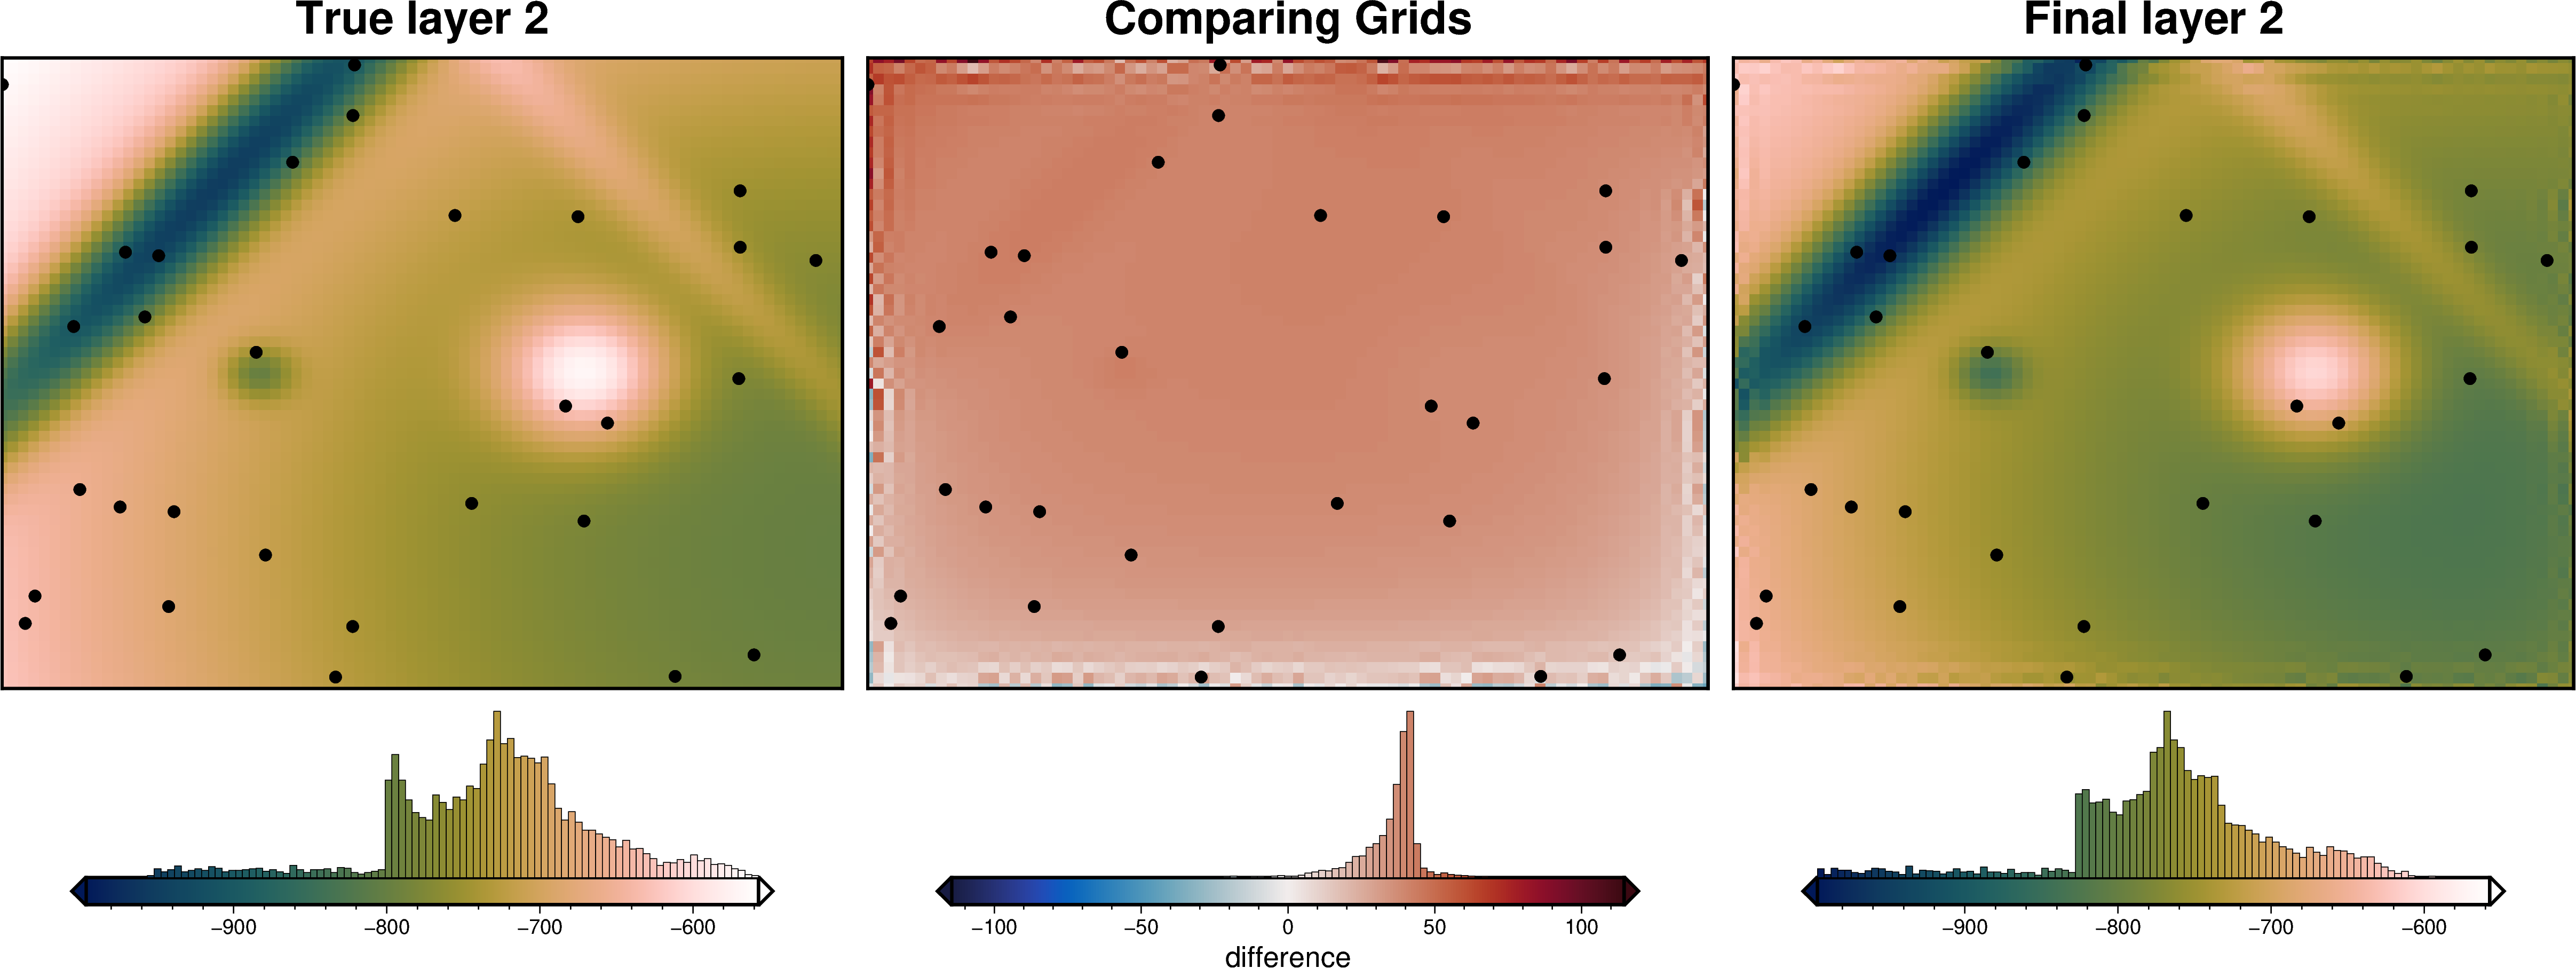

In [ ]:
grids = utils.grd_compare(
    true_layer2,
    final_layer2_noise,
    grid1_name='True layer 2',
    grid2_name='Final layer 2',
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    cmap='batlowW',
    # cmap="gist_earth",
    robust=True,
    points=constraint_points,
    hist=True,
    inset=False,
)

In [ ]:
grids = utils.grd_compare(
    final_layer2,
    final_layer2_noise,
    grid1_name='Final layer 2',
    grid2_name='Final layer 2 with noise',
    region=inversion_region,
    plot=True,
    plot_type="pygmt",
    cmap='batlowW',
    # cmap="gist_earth",
    robust=True,
    points=constraint_points,
    hist=True,
    inset=False,
)

returning original grid
returning original grid
returning original grid


makecpt [ERROR]: Option T: min >= max


returning original grid


histogram [ERROR]: Option -R parsing failure. Correct syntax:

-R<west>/<east>/<south>/<north>[+r]
Specify the min/max coordinates of your data region in user units. Use dd:mm[:ss] for regions
     given in arc degrees, minutes [and seconds]. Use -R<xmin>/<xmax>/<ymin>/<ymax>[+u<unit>] for
     regions given in projected coordinates, with <unit> selected from e|f|k|M|n|u [e]. If +u is
     set, projected regions centered on (0,0) may beset via -R<halfwidth>[/<halfheight>]+u<unit>,
     where <halfheight> defaults to <halfwidth> if not given. Use
     [yyyy[-mm[-dd]]]T[hh[:mm[:ss[.xxx]]]] format for time axes. Append +r if -R specifies the
     coordinates of the lower left and upper right corners of a rectangular area.
Use -Re and -Ra to set exact or approximate regions based on your input data (if applicable).
     Use -R<gridfile> to use its limits (and increments if applicable). Use -Rg and -Rd as
     shorthand for -R0/360/-90/90 and -R-180/180/-90/90. Derive region from closed pol

GMTCLibError: Module 'histogram' failed with status code 72:
histogram [ERROR]: Option -R parsing failure. Correct syntax:
histogram [ERROR]: Offending option -R-0.0/0.0/0/5435.1